<a href="https://colab.research.google.com/github/isuriperera1/HopeBridge/blob/Face-Recognition/Face_Recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.1


In [1]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

1/1 [==============================] - 0s 175ms/step


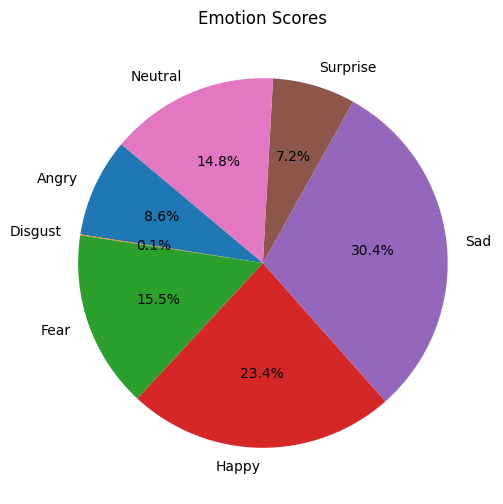

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained model
model_path = 'FR_Model.h5'
model = load_model(model_path)

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load and preprocess an image
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)  # Resize the image
    image_array = img_to_array(image)
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    image_array = np.expand_dims(image_array, axis=-1)  # Add channel dimension
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array /= 255.0  # Normalize the image
    return image_array

# Example: Provide the path to your test image
test_image_path = 'image.jpeg'  # Replace with your image path
image = preprocess_image(test_image_path, target_size=(48, 48))  # Resize to 48x48

# Make predictions
predictions = model.predict(image)[0]  # Get the first prediction from the batch

# Visualize the scores in a pie chart
plt.figure(figsize=(10, 6))
plt.pie(predictions, labels=emotion_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title('Emotion Scores')
plt.show()


In [3]:
def detect_depression_level(emotion_scores, emotion_labels):
    # Define groups
    negative_emotions = ['Angry', 'Disgust', 'Fear', 'Sad']
    positive_emotions = ['Happy', 'Surprise']
    neutral_emotion = ['Neutral']

    # Aggregate scores
    negative_score = sum(emotion_scores[emotion_labels.index(e)] for e in negative_emotions)
    positive_score = sum(emotion_scores[emotion_labels.index(e)] for e in positive_emotions)
    neutral_score = emotion_scores[emotion_labels.index('Neutral')]

    # Weighted depression score
    depression_score = (negative_score * 0.6) + (neutral_score * 0.3) - (positive_score * 0.1)

    # Define thresholds for depression levels
    if depression_score < 0.4:
        return "Low"
    elif 0.4 <= depression_score < 0.7:
        return "Moderate"
    else:
        return "High"

# Example usage with predictions
depression_level = detect_depression_level(predictions, emotion_labels)
print(f"Depression Level: {depression_level}")


Depression Level: Low


In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda
import json

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Define the depression detection logic
def depression_logic(emotion_scores):
    # Indices for 'Angry', 'Disgust', 'Fear', 'Sad'
    negative_indices = tf.constant([0, 1, 2, 4], dtype=tf.int32)
    # Indices for 'Happy', 'Surprise'
    positive_indices = tf.constant([3, 5], dtype=tf.int32)
    # Index for 'Neutral'
    neutral_index = tf.constant(6, dtype=tf.int32)

    negative_score = tf.reduce_sum(tf.gather(emotion_scores, negative_indices, axis=1))
    positive_score = tf.reduce_sum(tf.gather(emotion_scores, positive_indices, axis=1))
    neutral_score = tf.gather(emotion_scores, neutral_index, axis=1)

    depression_score = (negative_score * 0.6) + (neutral_score * 0.3) - (positive_score * 0.1)
    depression_score = tf.squeeze(depression_score) #Added this to make it a scalar

    return tf.cond(
        depression_score < 0.4,
        lambda: tf.constant("Low", dtype=tf.string),
        lambda: tf.cond(
            depression_score < 0.7,
            lambda: tf.constant("Moderate", dtype=tf.string),
            lambda: tf.constant("High", dtype=tf.string)
        )
    )

# Create a custom model
def create_depression_model():
    input_layer = Input(shape=(7,), name="emotion_scores")  # Input layer with 7 emotion scores
    output_layer = Lambda(depression_logic, name="depression_level")(input_layer)  # Custom logic as a Lambda layer
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Create the model
depression_model = create_depression_model()

# Save the model to an .h5 file
model_path = "depression_detection_model.h5"
depression_model.save(model_path)
print(f"Model saved to {model_path}")

# To test, load the model and pass a sample emotion score
loaded_model = tf.keras.models.load_model(
    model_path, custom_objects={"depression_logic": depression_logic}
)
sample_scores = np.array([[0.2, 0.1, 0.15, 0.05, 0.3, 0.1, 0.1]])  # Example input
predicted_level = loaded_model.predict(sample_scores)
print(predicted_level)


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to depression_detection_model.h5
1/1 [==============================] - 0s 75ms/step
b'Moderate'
